# <div style="text-align:center; border-radius:7px; padding:10px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b> Water Potability Prediction</b></div>

In [249]:
# Importation des bibliotheques de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math


# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score,learning_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Algorithmes de Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Metriques d'évaluation
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score)


from sklearn.inspection import permutation_importance

import joblib
import warnings
warnings.filterwarnings('ignore')


In [248]:
dataset = pd.read_csv('water-dataset.csv')

In [214]:
dataset.head()

,pH,Turbidity,Chlorine,Dissolved Oxygen,Temperature,Potability
0,7.45,15.60,0.70,7.56,50,False
1,7.83,2.41,0.77,7.58,0,True
2,8.09,2.57,0.58,7.29,50,True
3,7.16,1.19,0.53,7.83,25,True
4,7.59,4.29,0.58,7.98,25,True


In [215]:
print(f" - Nombre de lignes: {dataset.shape[0]}")
print(f" - Nombre de colonnes: {dataset.shape[1]}")

 - Nombre de lignes: 5000
 - Nombre de colonnes: 6


In [216]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pH                5000 non-null   float64
 1   Turbidity         5000 non-null   float64
 2   Chlorine          5000 non-null   float64
 3   Dissolved Oxygen  5000 non-null   float64
 4   Temperature       5000 non-null   int64  
 5   Potability        5000 non-null   bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 200.3 KB


In [217]:
dataset.describe()


,pH,Turbidity,Chlorine,Dissolved Oxygen,Temperature
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,7.565512,3.154142,0.932878,7.342220,24.735000
std,0.851572,1.772466,1.532965,1.004724,20.399461
min,6.100000,1.000000,0.500000,6.500000,0.000000
25%,7.010000,2.020000,0.630000,6.880000,0.000000
50%,7.510000,3.030000,0.750000,7.250000,25.000000
75%,8.020000,4.040000,0.880000,7.620000,50.000000
max,13.970000,19.720000,19.920000,19.940000,50.000000


# <div style="text-align:center; border-radius:7px; padding:10px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b> EDA </b></div>

In [218]:
dataset.duplicated().sum()

np.int64(0)

In [219]:
missing = dataset.isnull().sum()
missing

pH                  0
Turbidity           0
Chlorine            0
Dissolved Oxygen    0
Temperature         0
Potability          0
dtype: int64

Potability
True     4615
False     385
Name: count, dtype: int64


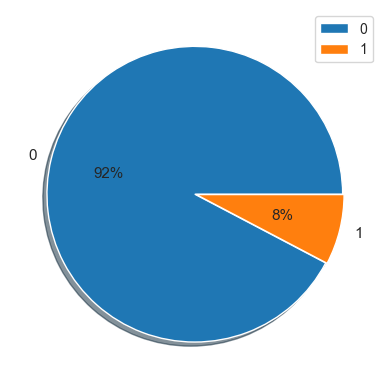

In [220]:
target = dataset['Potability'].value_counts()
print(target)
plt.pie(target, labels=[0, 1], explode=[0, 0.01], autopct='%.f%%', shadow=True)
plt.legend()
plt.savefig('potability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

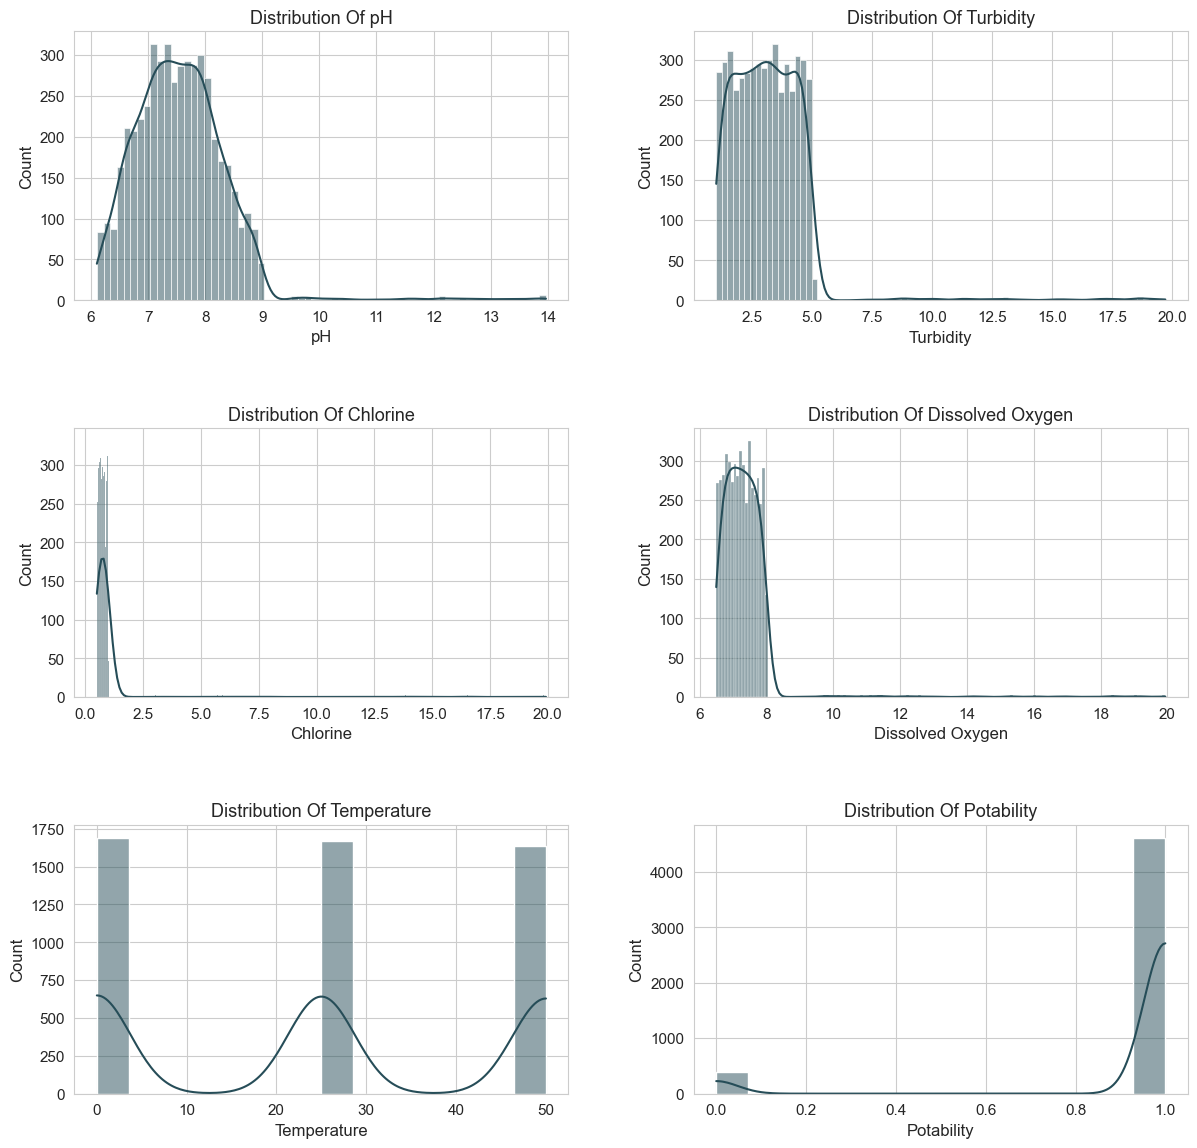

In [221]:
plt.figure(figsize=(13,20))
for k, cols in enumerate(dataset):
    plt.subplot(5,2, k+1)
    sns.histplot(x=cols,data=dataset, color='#264D58', kde=True)
    plt.title(f"Distribution Of {cols}", fontsize=13)
    plt.tight_layout(pad=4.0)   
plt.show()

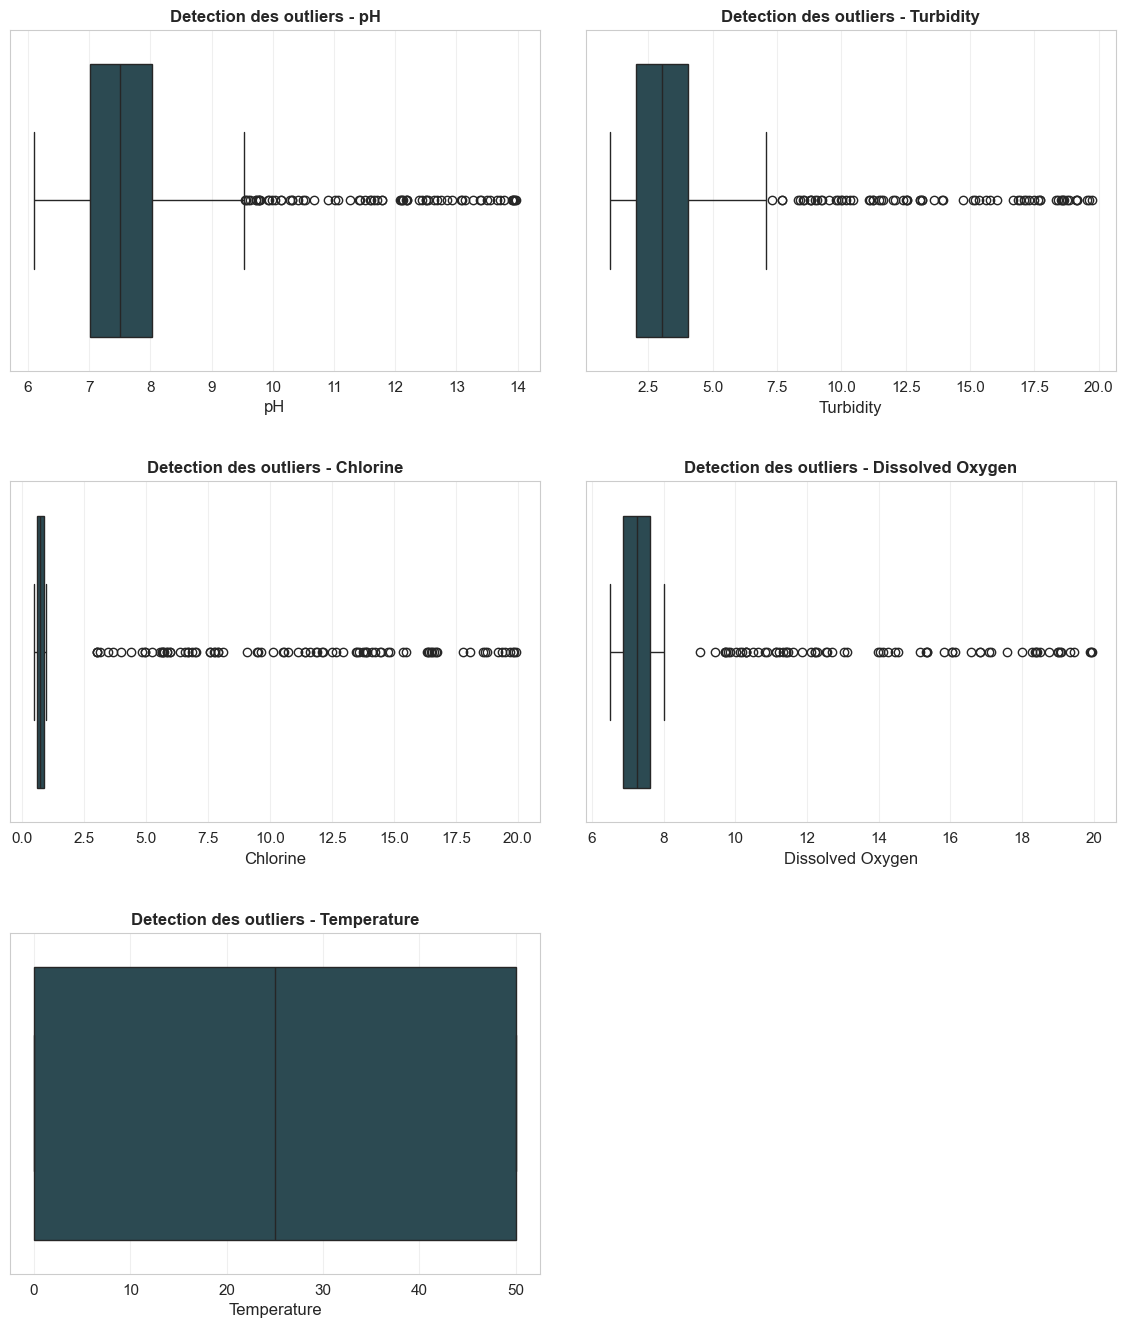

In [222]:
#outliers
features = ['pH', 'Turbidity', 'Chlorine', 'Dissolved Oxygen', 'Temperature']

plt.figure(figsize=(12, 14))

for i, col in enumerate(features):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x=dataset[col], color='#264D58')
    plt.title(f"Detection des outliers - {col}", fontsize=12, fontweight='bold')
    plt.xlabel(col)
    plt.grid(axis='x', alpha=0.3)

plt.tight_layout(pad=3.0)
plt.show()


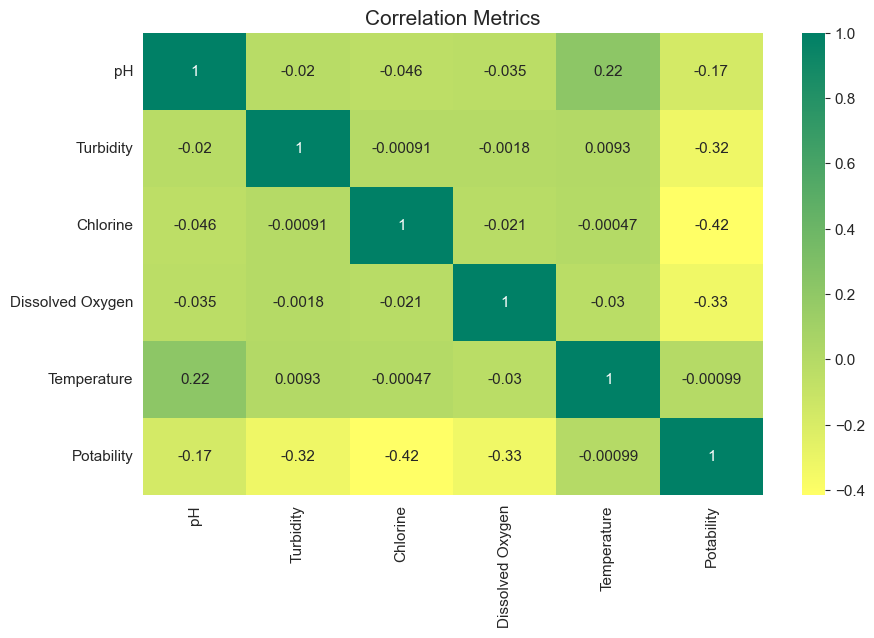

In [223]:
#matrice de corrilation

plt.figure(figsize=(10,6))
sns.heatmap(dataset.corr(), annot=True, cmap='summer_r')
plt.title('Correlation Metrics', fontsize=15)
plt.show()

In [224]:
# Convertir en numerique (1=Potable, 0=Non-Potable)
dataset['Potability_numeric'] = dataset['Potability'].astype(int)

In [225]:
features = ['pH', 'Turbidity', 'Chlorine', 'Dissolved Oxygen', 'Temperature']
X = dataset[features]
y = dataset['Potability_numeric']

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, 
                                                      stratify=y)

In [227]:
from collections import Counter
print(f"   Train: {X_train.shape[0]} ({Counter(y_train)[1]} potable, {Counter(y_train)[0]} non-potable)")
print(f"   Test:  {X_test.shape[0]} ({Counter(y_test)[1]} potable, {Counter(y_test)[0]} non-potable)")


   Train: 4000 (3692 potable, 308 non-potable)
   Test:  1000 (923 potable, 77 non-potable)


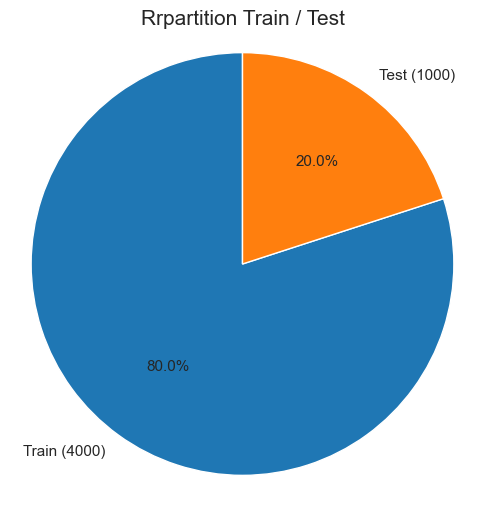

In [228]:
train_size, test_size = len(X_train), len(X_test)
# Diagramme 
plt.figure(figsize=(6, 6))
plt.pie(
    [train_size, test_size],
    labels=[f'Train ({train_size})', f'Test ({test_size})'],
    autopct='%1.1f%%',
    startangle=90
)

plt.title('Rrpartition Train / Test')
plt.axis('equal')
plt.show()


# <div style="text-align:center; border-radius:7px; padding:10px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>Scaling Data </b></div>

In [229]:
# Normalisation

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")

X_train_scaled: (4000, 5)
X_test_scaled: (1000, 5)


In [230]:
# Convertir en DataFrame pour affichage
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

In [231]:
print(f"\n Statistiques apres normalisation ")
print(X_train_scaled_df.describe().round(2))


 Statistiques apres normalisation 
            pH  Turbidity  Chlorine  Dissolved Oxygen  Temperature
count  4000.00    4000.00   4000.00           4000.00      4000.00
mean     -0.00      -0.00      0.00              0.00         0.00
std       1.00       1.00      1.00              1.00         1.00
min      -1.75      -1.19     -0.28             -0.83        -1.21
25%      -0.65      -0.62     -0.19             -0.46        -1.21
50%      -0.05      -0.07     -0.12             -0.10         0.01
75%       0.55       0.47     -0.03              0.28         1.23
max       7.67       9.03     12.43             12.47         1.23


# <div style="text-align:center; border-radius:7px; padding:10px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b>Models Building</b></div>

In [232]:

# Equilibrage des classes
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train_scaled, y_train)

print("Avant : ", Counter(y_train))
print("Apres  : ", Counter(y_train_balanced))


Avant :  Counter({1: 3692, 0: 308})
Apres  :  Counter({1: 3692, 0: 3692})


In [233]:
# Entrainement des modeles de classification

models = {
    
    'Logistic Regression': LogisticRegression(
            random_state=42, 
            max_iter=1000),

    'Random Forest': RandomForestClassifier(
        n_estimators = 200, # Nombre d'arbres dans 
        criterion = 'entropy' , #  gain d'information
        random_state = 42), # Reproductibilité

    'SVM': SVC(kernel='rbf',
               random_state=42, 
               probability=True),


    'XGBoost': XGBClassifier(random_state=42, 
                             eval_metric='logloss')
}



💦 Model Name: Logistic Regression
Accuracy Score: 0.92
Precision Score: 0.7419442266554384
Recall        : 0.9372
F1-Score      : 0.9579
__________________________________________________



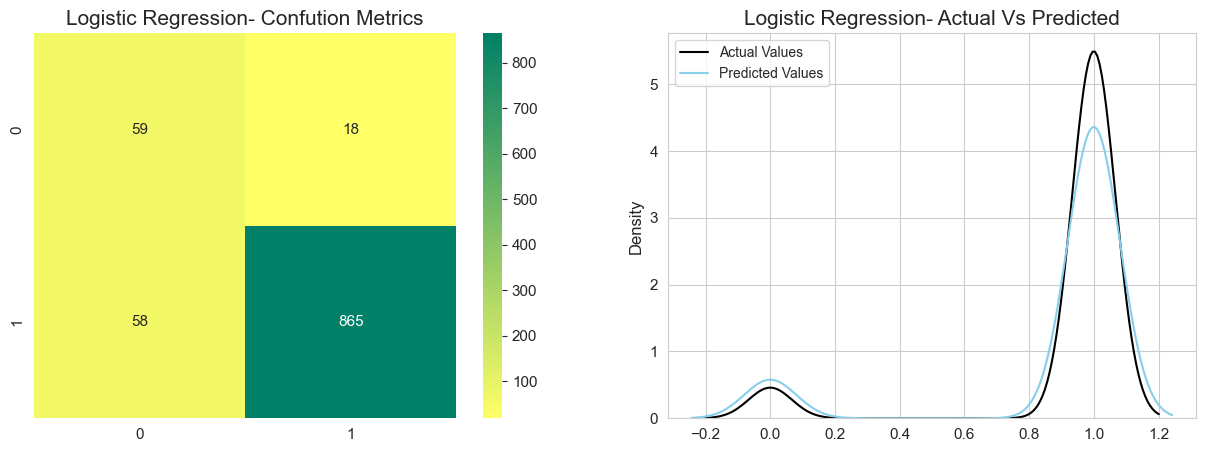


💦 Model Name: Random Forest
Accuracy Score: 0.97
Precision Score: 0.8926577808156756
Recall        : 0.9837
F1-Score      : 0.9832
__________________________________________________



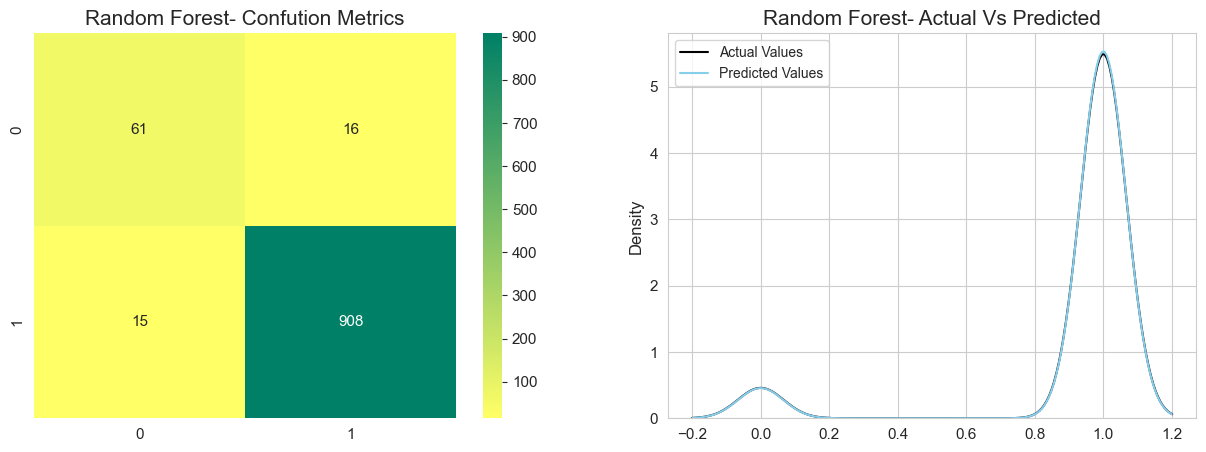


💦 Model Name: SVM
Accuracy Score: 0.98
Precision Score: 0.9914802981895634
Recall        : 1.0000
F1-Score      : 0.9914
__________________________________________________



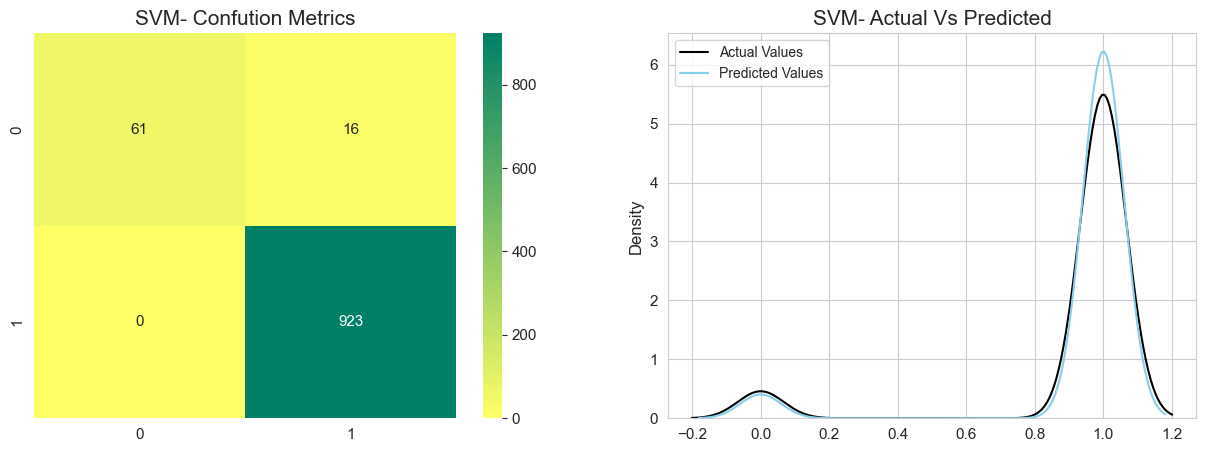


💦 Model Name: XGBoost
Accuracy Score: 0.96
Precision Score: 0.8725543478260869
Recall        : 0.9794
F1-Score      : 0.9810
__________________________________________________



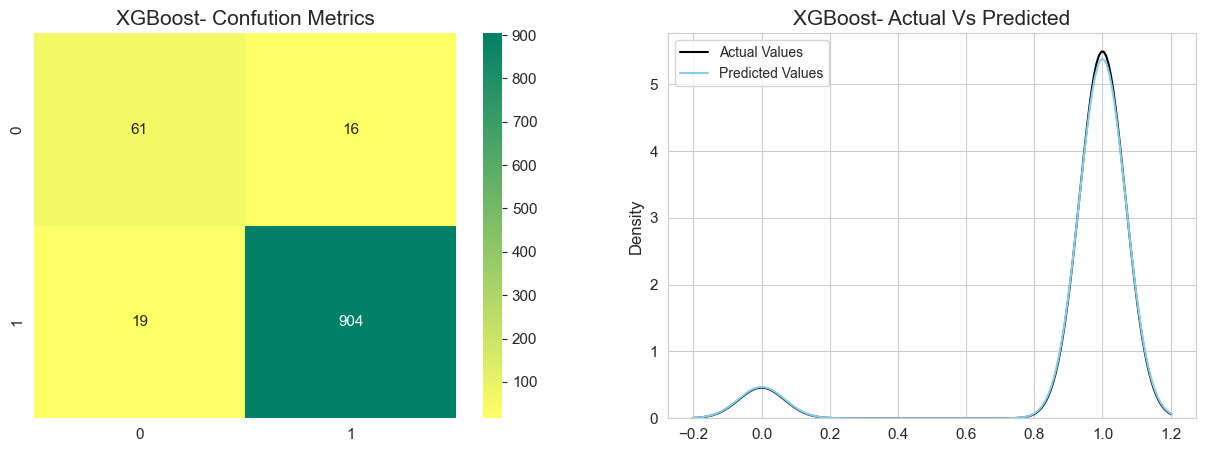

In [238]:
results = {}

for m_name, model in models.items():
    
    model.fit(X_train_balanced, y_train_balanced)
    y_preds = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_preds)
    precision= precision_score(y_test, y_preds, average='macro')
    recall = recall_score(y_test, y_preds)       
    f1 = f1_score(y_test, y_preds)
    
    print(f'\n💦 Model Name: {m_name}')
    print(f'Accuracy Score: {accuracy:.2f}')
    print(f'Precision Score: {precision}')
    print(f'Recall        : {recall:.4f}')
    print(f'F1-Score      : {f1:.4f}')
    print('_' * 50)
    print()

    results[m_name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_pred': y_preds
    }
    
    cm = confusion_matrix(y_test, y_preds)
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, cmap='summer_r', fmt='d')
    plt.title(f'{m_name}- Confution Metrics', fontsize=15)
    
    plt.subplot(1, 2, 2)
    sns.kdeplot(y_test.values, color='black', label='Actual Values')
    sns.kdeplot(y_preds, color='skyblue',label='Predicted Values')
    plt.title(f'{m_name}- Actual Vs Predicted', fontsize=15)
    plt.legend()
    plt.show()

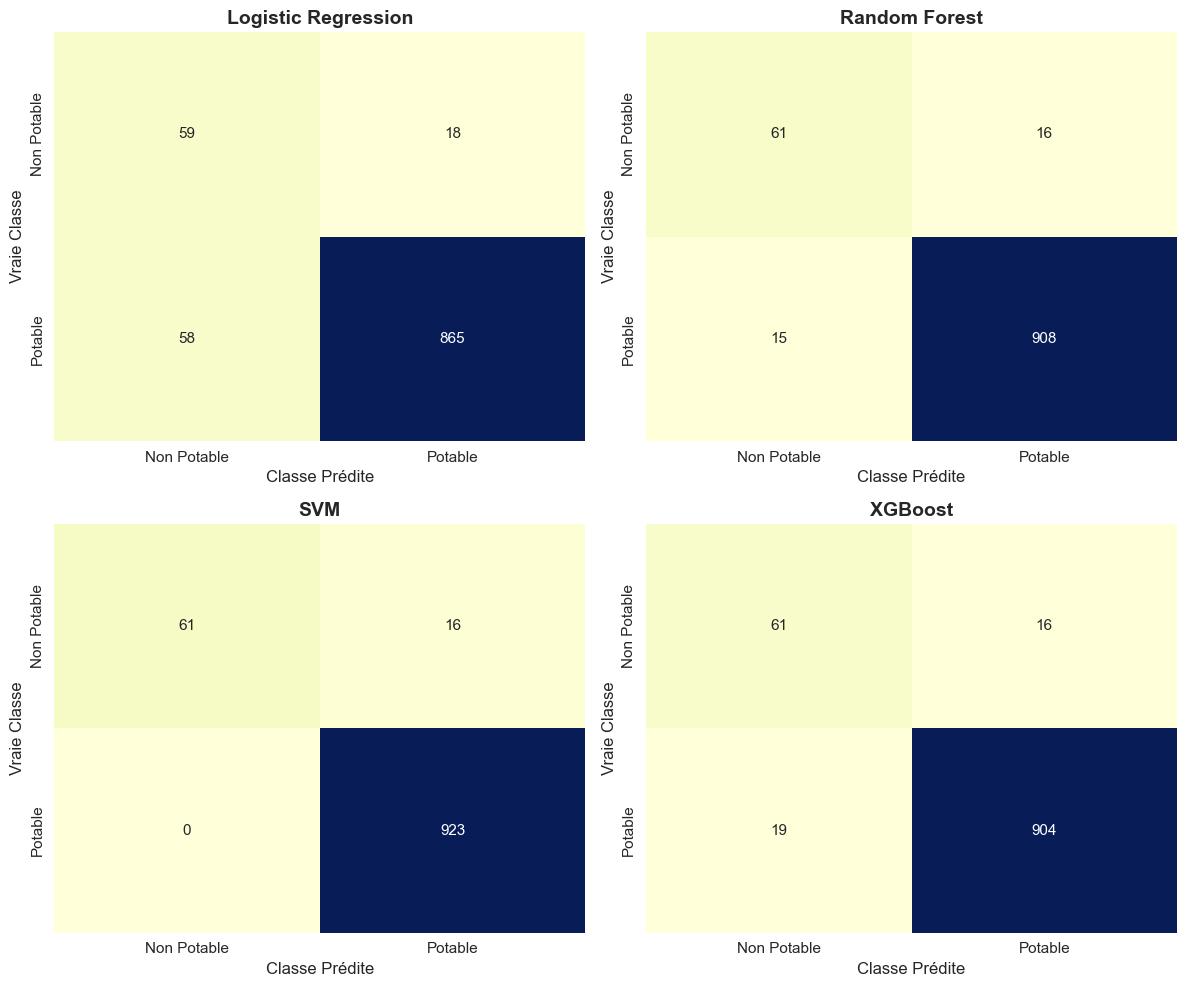

In [239]:
#mc
n_models = len(models)

n_cols = 2
n_rows = math.ceil(n_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten() 

for ax, (m_name, model) in zip(axes, models.items()):

    model.fit(X_train_balanced, y_train_balanced)
    y_preds = model.predict(X_test_scaled)

    cm = confusion_matrix(y_test, y_preds)
 
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=['Non Potable', 'Potable'],
                yticklabels=['Non Potable', 'Potable'],
                ax=ax, cbar=False)
    ax.set_title(f'{m_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Classe Prédite', fontsize=12)
    ax.set_ylabel('Vraie Classe', fontsize=12)

for i in range(n_models, n_rows*n_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [240]:
# DataFrame
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'Precision': [results[model]['precision'] for model in results.keys()],
    'Recall': [results[model]['recall'] for model in results.keys()],
    'F1-Score': [results[model]['f1_score'] for model in results.keys()]
})

In [241]:
# Trier par F1-Score
results_df = results_df.sort_values('F1-Score', ascending=False)

print("comparaison des modeles:")
print(results_df.to_string(index=False))

comparaison des modeles:
              Model  Accuracy  Precision   Recall  F1-Score
                SVM     0.984   0.991480 1.000000  0.991407
      Random Forest     0.969   0.892658 0.983749  0.983216
            XGBoost     0.965   0.872554 0.979415  0.981009
Logistic Regression     0.924   0.741944 0.937161  0.957918


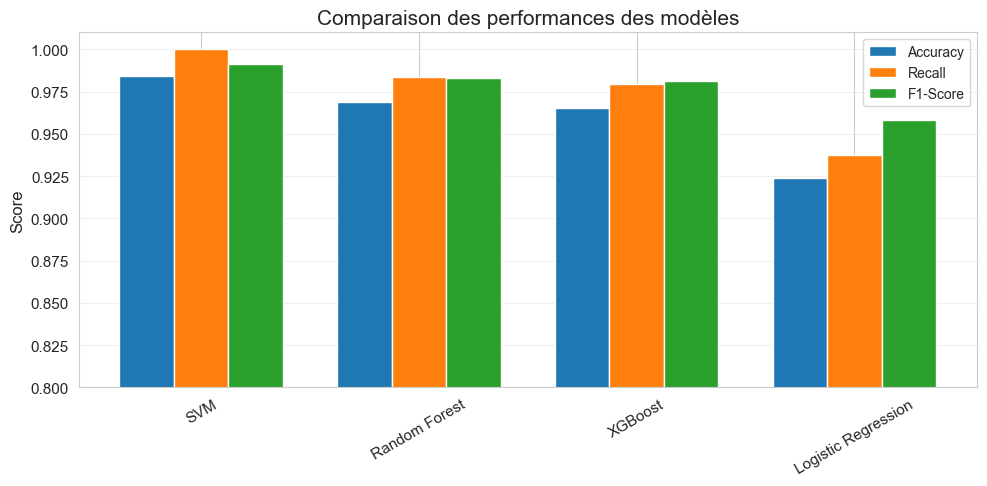

In [ ]:
#comparaison

x = np.arange(len(results_df))
w = 0.25

plt.figure(figsize=(10, 5))
plt.bar(x - w, results_df['Accuracy'], w, label='Accuracy')
plt.bar(x,     results_df['Recall'],   w, label='Recall')
plt.bar(x + w, results_df['F1-Score'],  w, label='F1-Score')

plt.xticks(x, results_df['Model'], rotation=30)
plt.ylabel("Score")
plt.title("Comparaison des performances des modèles")
plt.ylim(0.8, 1.01)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [243]:
best_model_name = results_df.iloc[0, 0]
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")


Best Model: SVM


# <div style="text-align:center; border-radius:7px; padding:10px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b> Evalution </b></div>

In [166]:
# Pr3dictions sur le jeu de test 
y_pred_best = best_model.predict(X_test_scaled)

print(classification_report(y_test, y_pred_best))


              precision    recall  f1-score   support

           0       1.00      0.79      0.88        77
           1       0.98      1.00      0.99       923

    accuracy                           0.98      1000
   macro avg       0.99      0.90      0.94      1000
weighted avg       0.98      0.98      0.98      1000



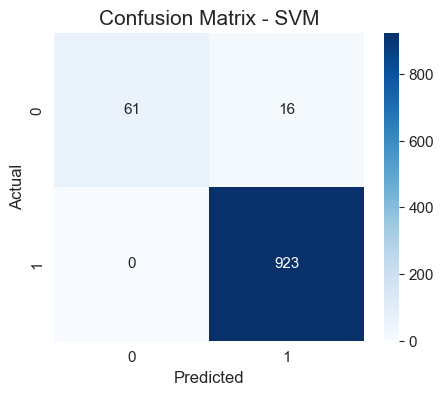

In [167]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [168]:
cv_scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')

cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f"Accuracy moyenne  : {cv_mean*100:.2f}%")
print(f"Ecart-type        : ±{cv_std*100:.2f}%")



Accuracy moyenne  : 89.68%
Ecart-type        : ±0.61%


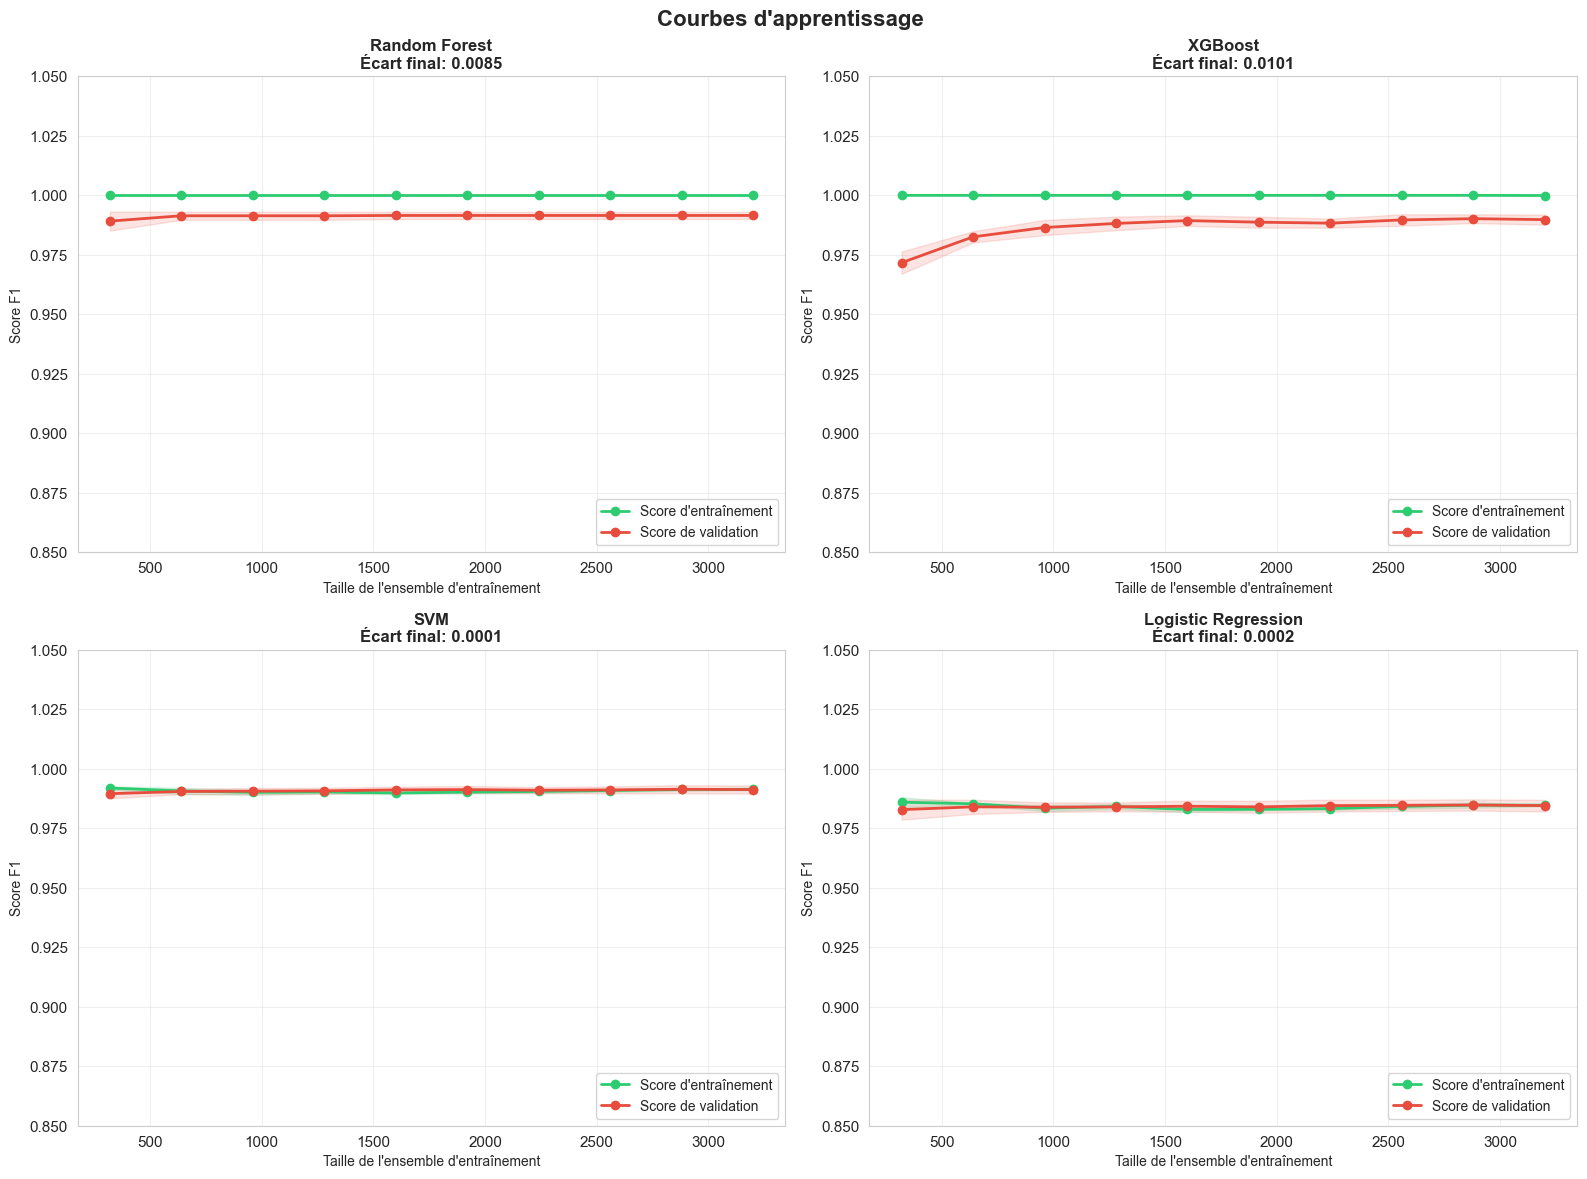

In [246]:

# courbes d'apprentissage
def plot_learning_curve(model, model_name, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5, 
        scoring='f1',
        n_jobs=-1,
        random_state=42
    )
    
    # Calculer les moyennes et écarts-types
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    return train_sizes, train_mean, train_std, val_mean, val_std

# models
models_to_analyze = ['Random Forest', 'XGBoost', 'SVM', 'Logistic Regression']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Courbes d\'apprentissage ', 
             fontsize=16, fontweight='bold')

axes = axes.ravel()

for idx, model_name in enumerate(models_to_analyze):
    
    model = results[model_name]['model']
    
    # Générer les courbes d'apprentissage
    train_sizes, train_mean, train_std, val_mean, val_std = plot_learning_curve(
        model, model_name, X_train_scaled, y_train
    )
    # Tracer les courbes
    axes[idx].plot(train_sizes, train_mean, 'o-', color='#2ecc71', 
                   label='Score d\'entraînement', linewidth=2, markersize=6)
    axes[idx].fill_between(train_sizes, train_mean - train_std, 
                           train_mean + train_std, alpha=0.15, color='#2ecc71')
    
    axes[idx].plot(train_sizes, val_mean, 'o-', color='#e74c3c', 
                   label='Score de validation', linewidth=2, markersize=6)
    axes[idx].fill_between(train_sizes, val_mean - val_std, 
                           val_mean + val_std, alpha=0.15, color='#e74c3c')
    
    # Calculer l'écart 
    gap = train_mean[-1] - val_mean[-1]
    
    axes[idx].set_title(f'{model_name}\nÉcart final: {gap:.4f}', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Taille de l\'ensemble d\'entraînement', fontsize=10)
    axes[idx].set_ylabel('Score F1', fontsize=10)
    axes[idx].legend(loc='lower right')
    axes[idx].grid(alpha=0.3)
    axes[idx].set_ylim([0.85, 1.05])
    
plt.tight_layout()
plt.show()


# <div style="text-align:center; border-radius:7px; padding:10px; color:white; margin:0; font-size:100%; font-family:Pacifico; background-color:skyblue; overflow:hidden"><b> Test </b></div>

In [171]:

nouvelle_eau = np.array([[7.5, 18.00, 0.7, 7.50, 50]])  
nouvelle_eau_scaled = scaler.transform(nouvelle_eau)

In [ ]:
prediction = best_model.predict(nouvelle_eau_scaled)
proba = best_model.predict_proba(nouvelle_eau_scaled)

if prediction[0] == 1:
    print(" Eau POTABLE")
else:
    print(" Eau NON POTABLE")

print(f"Probabilite eau potable : {proba[0][1]*100:.2f}%")


 Eau NON POTABLE
Probabilite eau potable : 0.00%


In [211]:

# Sauvegarde
joblib.dump(best_model, "svm_potabilite_model.pkl")
joblib.dump(scaler, "scaler_potabilite.pkl")

['scaler_potabilite.pkl']

In [ ]:
import joblib
import pandas as pd
import gradio as gr

best_model = joblib.load('svm_potabilite_model.pkl')
scaler = joblib.load('scaler_potabilite.pkl')  #

def predict(file):
    df = pd.read_csv(file.name)
    
    # Normalisation
    df_scaled = scaler.transform(df)
    
    # Prédiction
    y_pred = best_model.predict(df_scaled)
    
    # Conversion en 0/1
    y_pred_binary = [1 if p == 1 else 0 for p in y_pred]
    
    # Conversion lisible
    y_pred_labels = ["Potable" if p == 1 else "Non Potable" for p in y_pred_binary]
    
    return y_pred_labels

iface = gr.Interface(fn=predict, inputs=gr.File(), outputs="text")
iface.launch()


* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.
